In [1]:
from src.capstone.evaluation import Evaluator
from src.capstone.cbf import CBF
from src.capstone.settings import Env
from src.capstone.noise import DoubleIntegratorEnv

from double_integrator import DoubleIntegratorEnv

from bound_propagation.polynomial import Pow
from bound_propagation.linear import FixedLinear

import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

[0.0625 0.     2.5    0.    ]
[0.25 0.   5.   0.  ]
[0.5625 0.     7.5    0.    ]


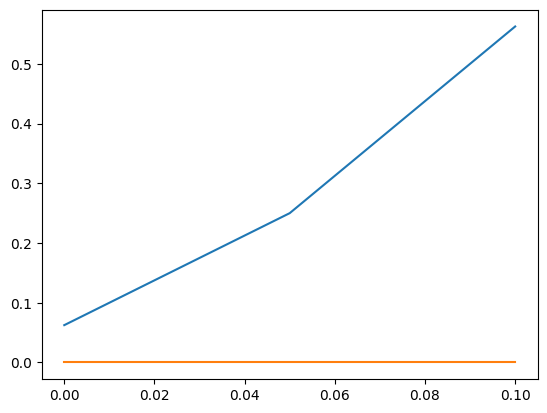

In [2]:
env = DoubleIntegratorEnv()
env.reset()
action = np.array([50., 0.])

states = []
ts = []

i = 0
terminated = False
while not terminated:
    state, _, terminated, _, _ = env.step(action)
    state = state.squeeze()

    states.append(state)
    ts.append(0.05 * i)
    
    i += 1

plt.plot(ts, [state[0] for state in states], label='x')
plt.plot(ts, [state[1] for state in states], label='y')
plt.show()

In [3]:
class NNDM(nn.Sequential):
    # input [x pos, y pos, x speed, y speed, ux, uy]
    
    def __init__(self):
        super(NNDM, self).__init__()
        self.dt = 0.05
        
        layer = nn.Linear(6, 4, bias=False)
        weights = torch.tensor([[1., 0., self.dt, 0., ((self.dt**2)/2), 0], 
                                [0., 1., 0., self.dt, 0., ((self.dt**2)/2)], 
                                [0., 0., 1., 0., self.dt, 0.], 
                                [0., 0., 0., 1., 0., self.dt]])
        layer.weight = nn.Parameter(weights)
        
        super(NNDM, self).__init__(layer)

nndm = NNDM()
nndm(torch.tensor([[0.5, 1., 1., 1., 1., 1.]]))


tensor([[0.5513, 1.0512, 1.0500, 1.0500]], grad_fn=<MmBackward0>)

In [4]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        
        self.layer = nn.Linear(2, 2)
        
        # dummy output of u=0
        self.layer.weight = nn.Parameter(torch.tensor([[0., 0., 0., 0.], [0., 0., 0., 0.]]))
        self.layer.bias = nn.Parameter(torch.tensor([50., 0.]))
    
    def forward(self, x):
        return self.layer(x)
    
    def select_action(self, x, exploration=False):
        if exploration:
            raise ValueError('This model is not implemented for exploration')
        else:
            return self.forward(x)

In [5]:
policy = Agent()

In [15]:
class DoubleIntegrator(Env):
    def __init__(self):
        self.is_discrete = False
        
        self.settings = {
            'noise': [],
            'max_frames': 999
        }
        
        self.h_function = nn.Sequential(
            FixedLinear(
                torch.tensor([
                    [1., 0, 0, 0],
                    [0, 1, 0, 0]
                ]),
                torch.tensor([0., 0.])
            ),
            Pow(2),
            FixedLinear(
                torch.tensor([
                    [-1 / 0.5 ** 2, 0],
                    [0, -1 / 0.5 ** 2]
                ]),
                torch.tensor([1., 1.])
            )
        )

        self.h_ids = [0, 1]
        self.std = [0.001, 0.001]
        self.env = DoubleIntegratorEnv()

In [16]:
env = DoubleIntegrator()

In [17]:
cbf = CBF(env, nndm, policy,
          alpha=[0.9, 0.9],
          delta=[0., 0.],
          no_action_partitions=2,
          no_noise_partitions=2,
          stochastic=True)

In [18]:
evaluator = Evaluator(env, cbf)
f, h = evaluator.mc_simulate(policy, 100, cbf_enabled=True, seed=[0., 0., 0., 0.])

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[0., 0., 0., 0.]])
tensor([[0.0625, 0.0000, 2.5000, 0.0000]])


TypeError: '>' not supported between instances of 'float' and 'NoneType'